<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/econometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelling & Analyzing (Gaussian) White Noise & Random Walk Processes**

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from scipy import stats
import numpy as np
from random import gauss
from random import seed
from pandas import Series
import datetime
from statsmodels.tsa.stattools import adfuller
import scipy
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import pandas.util.testing as tm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **White Noise & Residual Analysis**

## **Relevance of White Noise**

For the demonstration of data analysis as first important step before model building, white noise processes have some desirable properties, which makes it clearer and easier to understand:

**A white noise process has following conditions**

* Mean (level) is zero (does not change over time - stationary process)
* Variance is constant (does not change over time - stationary process)
* Zero autocorrelation (values do not correlate with lag values)

**What is a White Noise Time Series?**

* A time series is white noise if the variables are independent and identically distributed with a mean of zero.
* This means that all variables have the same variance (sigma^2) and each value has a zero correlation with all other values in the series.
* If the variables in the series are drawn from a Gaussian distribution, the series is called Gaussian white noise (There is of course not only Gaussian white noise processes, but also Levy etc.)

**White noise is an important concept in time series analysis and forecasting**

* **Predictability**: If your time series is white noise, then, by definition, it is random. You cannot reasonably model it and make predictions.
* **Model Diagnostics**: The statistics and diagnostic plots can be uses on time series to check if it is white noise. The series of errors from a time series forecast model should ideally be white noise. If the series of forecast errors are not white noise, it suggests improvements could be made to the predictive model. 

Time series data are expected to contain some white noise component on top of the signal generated by the underlying process. For example:

y(t) = signal(t) + noise(t)

* Once predictions have been made by a time series forecast model, they can be collected and analyzed. The series of forecast errors should ideally be white noise.
* When forecast errors are white noise, it means that all of the signal information in the time series has been harnessed by the model in order to make predictions. All that is left is the random fluctuations that cannot be modeled.
* A sign that model predictions are not white noise is an indication that further improvements to the forecast model may be possible.


## **Residual Analysis**

**What are residuals?**

For most (time series) models, the residuals are difference between observation and its corresponding estimated (fitted) value:

$e_{t} = y_{t} - \hat{y}_{t}$

**Why is it important to analyze residuals?**

Residuals are useful in checking whether a model has adequately captured the information in the data. In a good model the residuals are stationary. However one can classify the stationarity criteria in two distinct groups for residual analysis:

A good forecasting method will yield residuals with the following properties:

**1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.**

**2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.**

Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

If either of these properties is not satisfied, then the forecasting method can be modified to give better forecasts. Adjusting for bias is easy: if the residuals have mean m, then simply add m to all forecasts and the bias problem is solved. Fixing the correlation problem is harder, and we will not address it until Chapter 9.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.

**3. The residuals have constant variance.**

**4. The residuals are normally distributed.**

These two properties make the calculation of prediction intervals easier (see Section 3.5 for an example). However, a forecasting method that does not satisfy these properties cannot necessarily be improved. Sometimes applying a Box-Cox transformation may assist with these properties, but otherwise there is usually little that you can do to ensure that your residuals have constant variance and a normal distribution. Instead, an alternative approach to obtaining prediction intervals is necessary. Again, we will not address how to do this until later in the book.

[Source 1](https://otexts.com/fpp2/residuals.html) 
[Source2 ](https://otexts.com/fpp2/prediction-intervals.html)

## **Create (Gaussian) White Noise**

In [0]:
# Set seed for reproducibility and hyperparameter
seed(1)
mean = 0.0
sigma = 1.0
periods = 5000

# Create White Noise
whitenoise = [gauss(mean, sigma) for i in range(periods)]
whitenoise = pd.DataFrame(data=Series(whitenoise), columns=['whitenoise'])

# Create Time Series
ts = pd.date_range('2010-01-01', periods=periods, freq='D')
ts = pd.DataFrame(data=ts, columns=['ts'])

# Merge and Set Index
whitenoise = pd.concat([ts, whitenoise], axis=1).set_index('ts')
whitenoise.head()

,whitenoise
ts,
2010-01-01,1.288185
2010-01-02,1.449446
2010-01-03,0.066336
2010-01-04,-0.764544
2010-01-05,-1.092173


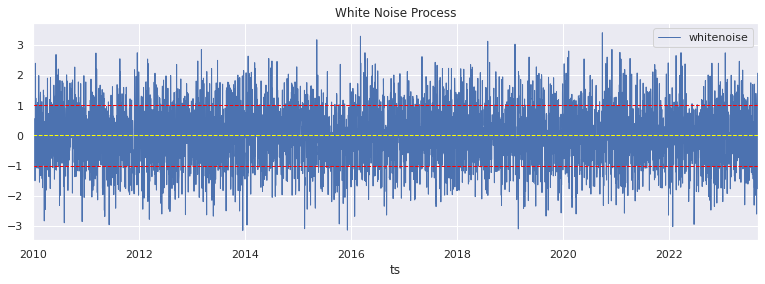

In [0]:
# Visualize Series
sns.set(rc={'figure.figsize':(13, 4), "lines.linewidth": 1.0})
whitenoise.plot(title='White Noise Process')
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.0)
plt.axhline(y=-1, color='red', linestyle='--', linewidth=1.0)
plt.axhline(y=0, color='yellow', linestyle='--', linewidth=1.0)

# **Random Walks (with Drift) & Time Series**

## **Characteristics & Relevance of Random Walks**

* Random walk is another time series model where the current observation is equal to the previous observation with a random step up or down. Known as a stochastic or random process.
* y(t) = B0 + B1*X(t-1) + e(t)
* A random walk is different from a list of random numbers because the next value in the sequence is a modification of the previous value in the sequence. The process used to generate the series forces dependence from one-time step to the next. This dependence provides some consistency from step-to-step rather than the large jumps that a series of independent, random numbers provides. It is this dependency that gives the process its name as a “random walk” or a “drunkard’s walk”. https://en.wikipedia.org/wiki/Random_walk (Geometric Brownian motion)

**Random Walk and Autocorrelation**

* We can calculate the correlation between each observation and the observations at previous time steps. Given the way that the random walk is constructed, we would expect a strong autocorrelation with the previous observation and a linear fall off from there with previous lag values.

**Stationarity**

* A stationary time series is one where the values are not a function of time. Given the way that the random walk is constructed and the results of reviewing the autocorrelation, we know that the observations in a random walk are dependent on time.

* The current observation is a random step from the previous observation. Therefore we can expect a random walk to be non-stationary. In fact, all random walk processes are non-stationary. Note that not all non-stationary time series are random walks.

* Additionally, a non-stationary time series does not have a consistent mean and/or variance over time. A review of the random walk line plot might suggest this to be the case. We can confirm this using a statistical significance test, specifically the Augmented Dickey-Fuller test.

**Higher Dimensions**

* In higher dimensions, the set of randomly walked points has interesting geometric properties. In fact, one gets a discrete fractal, that is, a set which exhibits stochastic self-similarity on large scales. On small scales, one can observe “jaggedness” resulting from the grid on which the walk is performed. Two books of Lawler referenced below are a good source on this topic. The trajectory of a random walk is the collection of points visited, considered as a set with disregard to when the walk arrived at the point. In one dimension, the trajectory is simply all points between the minimum height and the maximum height the walk achieved (both are, on average, on the order of ?n).

**Prediction**

* A random walk is unpredictable; it cannot reasonably be predicted. Given the way that the random walk is constructed, we can expect that the best prediction we could make would be to use the observation at the previous time step as what will happen in the next time step. Simply because we know that the next time step will be a function of the prior time step. This is often called the naive forecast, or a persistence model. We can implement this in Python by first splitting the dataset into train and test sets, then using the persistence model to predict the outcome using a rolling forecast method. Once all predictions are collected for the test set, the mean squared error is calculated.

## **Financial Time Series**

**Is time series a random walk?**

Your time series may be a random walk. Some ways to check if your time series is a random walk are as follows:

* The time series shows a strong temporal dependence that decays linearly or in a similar pattern.
* The time series is non-stationary and making it stationary shows no obviously learnable structure in the data.
* The persistence model provides the best source of reliable predictions.

* This last point is key for time series forecasting. Baseline forecasts with the persistence model quickly flesh out whether you can do significantly better. If you can’t, you’re probably working with a random walk. Many time series are random walks, particularly those of security prices over time. The random walk hypothesis is a theory that stock market prices are a random walk and cannot be predicted. 

* "A random walk is one in which future steps or directions cannot be predicted on the basis of past history. When the term is applied to the stock market, it means that short-run changes in stock prices are unpredictable." - Page 26, A Random Walk down Wall Street: The Time-tested Strategy for Successful Investing. https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/


**Applications of Random Walks**

* In computer networks, random walks can model the number of transmission packets buffered at a server.
* In population genetics, random walk describes the statistical properties of genetic drift.
* In image segmentation, random walks are used to determine the labels (i.e., “object” or “background”) to associate with each pixel.
* In brain research, random walks and reinforced random walks are used to model cascades of neuron firing in the brain.
* Random walks have also been used to sample massive online graphs such as online social networks.

## **Create Random Walk (with Drift)**

**1D Random Walk Time Series**

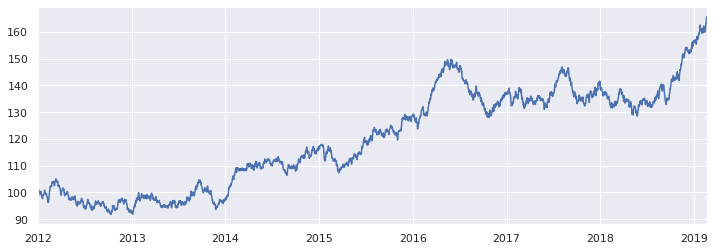

In [0]:
import numpy as np
sns.set(rc={'figure.figsize':(12, 4)})

def geometric_brownian_motion(T = 1, N = 100, mu = 0.1, sigma = 0.01, S0 = 20): 
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt) ### standard brownian motion ###
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion ###
    return S

dates = pd.date_range('2012-01-01', '2019-02-22')
T = (dates.max()-dates.min()).days / 365
N = dates.size
start_price = 100
randomwalk = pd.Series(
    geometric_brownian_motion(T, N, sigma=0.1, S0=start_price), index=dates)

randomwalk.plot()

**2D Random Walk**

In [0]:
# Python code for 2D random walk. 
import numpy 
import pylab 
import random 
  
# defining the number of steps 
n = 100000
  
#creating two array for containing x and y coordinate 
#of size equals to the number of size and filled up with 0's 
x = numpy.zeros(n) 
y = numpy.zeros(n) 
  
# filling the coordinates with random variables 
for i in range(1, n): 
    val = random.randint(1, 4) 
    if val == 1: 
        x[i] = x[i - 1] + 1
        y[i] = y[i - 1] 
    elif val == 2: 
        x[i] = x[i - 1] - 1
        y[i] = y[i - 1] 
    elif val == 3: 
        x[i] = x[i - 1] 
        y[i] = y[i - 1] + 1
    else: 
        x[i] = x[i - 1] 
        y[i] = y[i - 1] - 1
      
  
# plotting stuff: 
sns.set(rc={'figure.figsize':(13, 10)})
pylab.title("Random Walk ($n = " + str(n) + "$ steps)") 
pylab.plot(x, y) 
pylab.savefig("rand_walk"+str(n)+".png",bbox_inches="tight",dpi=600) 
pylab.show() 

# **Select Series**

# **Distribution**

In [0]:
series = whitenoise # or: randomwalk

## **Relevance**

* Gaussian White Noise Processes are drawn from a normal distribution. This should be reflected in distribution plots and goodness of fit nests.
* Generally it is good to know the underlying distribution of processes for example when constructing a better (custom) activation function or cost function.

In [0]:
series.describe(percentiles=[0.05, 0.95])

,whitenoise
count,5000.000000
mean,-0.000236
std,0.991748
min,-3.149965
5%,-1.663347
50%,-0.006930
95%,1.656811
max,3.400552


Mean is nearly 0.0 and the standard deviation is nearly 1.0. Some variance is expected given the small size of the sample. If we had more data, it might be more interesting to split the series in half and calculate and compare the summary statistics for each half. We would expect to see a similar mean and standard deviation for each sub-series.

In [0]:
# First central moment: Mean
series.mean()

whitenoise   -0.000236
dtype: float64

In [0]:
# Second central moment: Variance
series.var()

whitenoise    0.983565
dtype: float64

In [0]:
# Third central moment: Skewness ('Higher moment')
series.skew()

whitenoise   -0.001609
dtype: float64

In [0]:
# Forth central moment: Kurtosis ('Higher moment')
series.kurt()

whitenoise   -0.090712
dtype: float64

In [0]:
# Compute specific percentiles
series.quantile(0.75)

whitenoise    0.667429
Name: 0.75, dtype: float64

## **Distribution Plots**

**Distribution Plot**

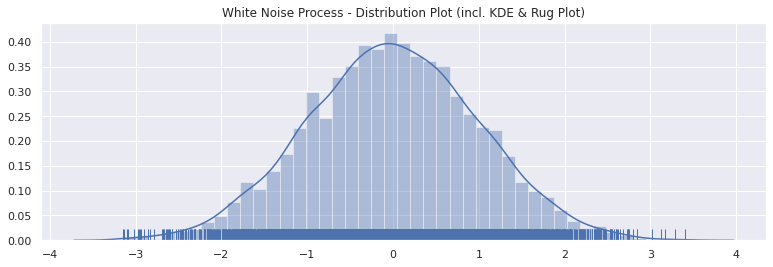

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((series), hist=True, rug=True).set_title('White Noise Process - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

**KDE Plot**

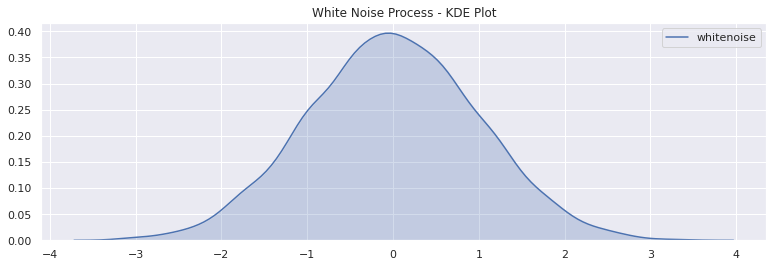

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.kdeplot(series.whitenoise, shade=True).set_title('White Noise Process - KDE Plot')
plt.show()

**Boxplot**

Text(0.5, 1.0, 'White Noise Process - Boxplot')

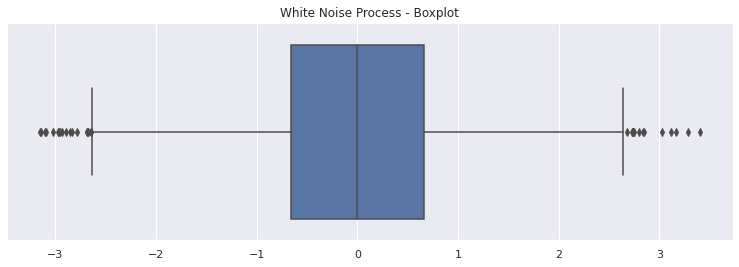

In [0]:
sns.boxplot(series).set_title('White Noise Process - Boxplot')

**QQ Plot**

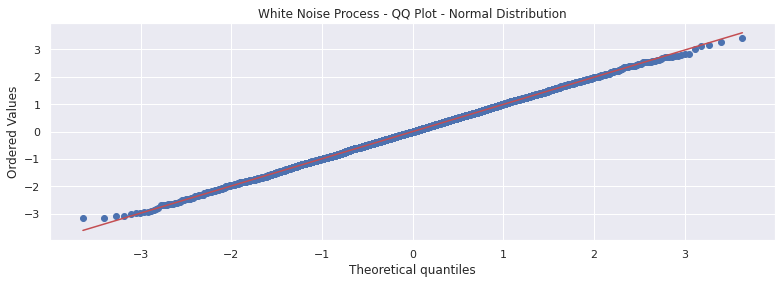

In [0]:
stats.probplot(series.whitenoise, dist="norm", plot=plt)
plt.title('White Noise Process - QQ Plot - Normal Distribution')
plt.show()

## **Statistical Tests (Goodness of Fit)**

**Normal Test**

* Test whether a sample differs from a normal distribution.
* This function tests the null hypothesis that a sample comes from a normal distribution. 
* It is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality.
* Historically, the third and fourth standardized moments (skewness and kurtosis) were some of the earliest tests for normality.

In [0]:
# Normal Test. H0: sample comes from a normal distribution
scipy.stats.normaltest(series)

NormaltestResult(statistic=array([1.7988695]), pvalue=array([0.40679954]))

**Shapiro–Wilk Test**

* tests the null hypothesis that the data was drawn from a normal distribution.
* Monte Carlo simulation has found that Shapiro–Wilk has the best power for a given significance, followed closely by Anderson–Darling when comparing the Shapiro–Wilk, Kolmogorov–Smirnov, Lilliefors and Anderson–Darling tests.
* For N > 5000 the W test statistic is accurate but the p-value may not be.
* The chance of rejecting the null hypothesis when it is true is close to 5% regardless of sample size.

In [0]:
# Shapiro–Wilk Test. H0: data was drawn from a normal distribution
stats.shapiro(series.whitenoise)

(0.9996960163116455, 0.6947302222251892)

**Anderson-Darling Test**

* Anderson Darling tests the null hypothesis whether the sample from the population follows a particular distribution (default: normal).
* For the Anderson-Darling test, the critical values depend on which distribution is being tested against. 
* This function works for normal, exponential, logistic, or Gumbel (Extreme Value Type I) distributions.



In [0]:
# Anderson-Darling Test. H0: sample from the population follows a particular distribution (default: normal)
stats.anderson(series.whitenoise)

AndersonResult(statistic=0.17225517577207938, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

**Kolmogorov-Smirnov Test**

* Test of the distribution G(x) of an observed random variable against a given distribution F(x) (quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution, or between the empirical distribution functions of two samples.)
* Under null hypothesis the two distributions are identical, G(x)=F(x).
* Only works if the mean and the variance of the normal are assumed known under the null hypothesis

In [0]:
# Kolmogorov-Smirnov Test. H0: The two distributions are identical (e.g. against normal)
stats.kstest(series, 'norm')

KstestResult(statistic=0.9996637501786144, pvalue=0.0)

**Jarque-Bera Test**

* Compares sample skewness and kurtosis to 0 and 3, their values under normality.
* This test only works for a large enough number of data samples (>2000) as the test statistic asymptotically has a Chi-squared distribution with 2 degrees of freedom.
* Null hypothesis: sample is normal distributed.
* The test has weakness. In particular, the test has low power for distributions with short tails, especially for bimodal distributions. Some authors have declined to include its results in their studies because of its poor overall performance

In [0]:
# Jarque-Bera Test. H0: sample is normal distributed
stats.jarque_bera(series)

(1.7586207168611774, 0.41506906187895287)

All P-values > 0.05. Don't reject any HO. Distribution is normal



---



# **Autocorrelation**

## **Relevance**

* Used as input parameter in classical time series models, such as (S)Arima(x), Garch or Auto Vectorregression (VaR), to identify for example seasonality.
* Most financial time series exhibit some form of autocorrelation
* A series can contain autocorrelation an be stationary, as long as there is a constant autocorrelation structure over time (and series has no trend, constant variance over time, and no periodic fluctuations like seasonality).
* But if autocorrelation is zero does NOT mean that a process is stationary. Generally autocorrelation doesn't cause non-stationarity, and non-stationarity doesn't require autocorrelation.
* Can be used to test whether a series is independent (as part of IID), by testing that the autocorrelations at all non zero lags are 0 (using if the data have an index ordering).
* Portmanteau tests are statistical tests that can be used to test whether several autocorrelation coefficients differ significantly from zero. This is particularly important when checking the residuals' freedom from autocorrelation during the diagnosis phase of a time series analysis. Portmanteau tests are purely significance tests. You are not testing against a clearly formulated counter-hypothesis. The test statistic is called Q statistic.

## **Autocorrelation Plots**

**Autocorrelation Plot**

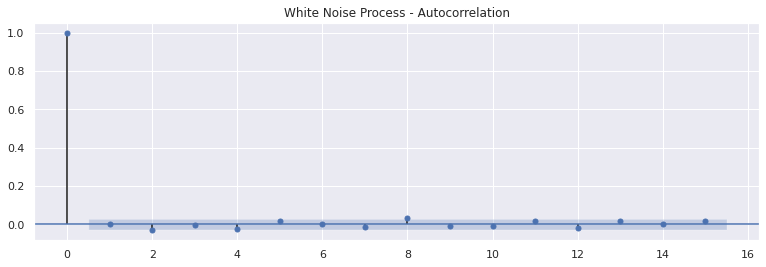

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sm.graphics.tsa.plot_acf(series.squeeze(), lags=15)
plt.title('White Noise Process - Autocorrelation')
plt.show()

There may be some spikes above the 95% and 99% confidence level, but these are a statistical fluke.

**Partial Autocorrelation Lag Plot**

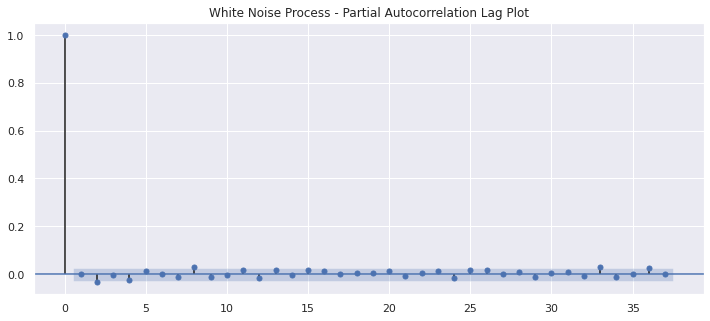

In [0]:
plot_pacf(series)
plt.title('White Noise Process - Partial Autocorrelation Lag Plot')
plt.show()

**Lag Plot**

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


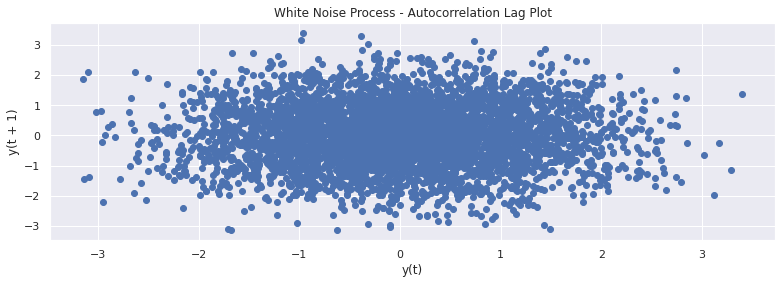

In [0]:
lag_plot(series)
plt.title('White Noise Process - Autocorrelation Lag Plot')
plt.show()

## **Statistical Tests**

**Durban-Watson Statistic**

* Is a test for autocorrelation in the residuals from a statistical regression analysis.
* The null hypothesis of the test is that there is no serial correlation
* This statistic will always be between 0 and 4. Closer to 0: evidence for positive serial correlation, closer to 4: negative serial correlation. 2 means no autocorrelation.

In [0]:
# Durban-Watson Statistic. Value 2: no serial correlation. 0: positive correlation. 4: negative correlation
statsmodels.stats.stattools.durbin_watson(series, axis=0)

array([1.99873153])

Test statistic is close to 2. There is no autocorrelation present.

**Ljung-Box Q Statistic**

* Ljung–Box test is an improved version of the Box–Pierce test
* Returns Ljung-Box Q-statistic for autocorrelation parameters and p-value
* Examining the null hypothesis of independence in a given time series.
* Instead of testing randomness at each distinct lag, it tests the "overall" randomness based on a number of lags, and is therefore a portmanteau test.
* The Ljung-Box Q (LBQ) statistic tests the null hypothesis that autocorrelations up to lag k equal zero (that is, the data values are random and independent up to a certain number of lags--in this case 12). 
* If the LBQ is greater than a specified critical value, autocorrelations for one or more lags might be significantly different from zero, indicating the values are not random and independent over time.
* https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/supporting-topics/diagnostic-checking/what-is-the-ljung-box-q-statistic/
* There are some strong voices in the Econometrics community against the validity of the Ljung-Box Q-statistic for testing for autocorrelation based on the residuals from an autoregressive model (i.e. with lagged dependent variables in the regressor matrix). The argument against the Ljung-Box test is the same as the one raised against another omnipresent autocorrelation test, the "Durbin-Watson" one: with lagged dependent variables in the regressor matrix, the test is biased in favor of maintaining the null hypothesis of "no-autocorrelation". Additionally there is a low power of the test.

In [0]:
# Determine number of lags based on periods in time series for Ljung-Box test
# Formula: (Lags = (Number of Observations / 2) -2)
np.int_((periods/2)-2)

2498

This is the number of lags that needs to be integrated into the Ljung Box Test. Instead of inserting the final number manually, we'll add the formula for automatic determination.

In [0]:
# Ljung-Box test of autocorrelation in residuals. H0: independence in a given time series
sm.stats.acorr_ljungbox(series.whitenoise, lags=[(np.int_((periods/2)-2))])

(array([2360.64190127]), array([0.97561779]))

P-value > zero. Do not reject H0. Series is independent.

**BDS Independence Test**

* Brock, W. Dechert and J. Scheinkman
* BDS test statistic for independence of a time series
* Time Series is IID (= Null Hypothesis)
* The BDS test is free of nuisance parameters, but it suffers from some problems. For instance, the power of the BDS test depends on the choice of value of the dimensional distance parameter. Another problem is that the BDS test, though asymptotically normal under the null, has high rates of Type I error, especially for non Gaussian data

In [0]:
# BDS Independence Test. H0: Time Series is IID
sm.tsa.stattools.bds(series.whitenoise, max_dim=6, epsilon=None, distance=1.5)

(array([2.20528503, 1.79865181, 1.73497756, 1.50245135, 1.06946712]),
 array([0.0274341 , 0.07207378, 0.08274478, 0.13298058, 0.28485924]))

P-value is > 0.05. Series is IID.

**Breusch–Godfrey Test**

Some econometricians prefer the "Langrange Multiplier" test of Breusch and Godfrey.

In [0]:
# statsmodels.stats.diagnostic.acorr_breusch_godfrey(series, nlags=None, store=False)



---



# **Stationarity**

## **Revelance**

**Revelance**

* Certain statistical tests demand stationarity (e.g. Granger causality test)
* Especially classic time series models demand stationarity, otherwise forecasts are biased.

**Weak (Second Order) Stationarity**

Following Statistical properties don’t change over time:
1. constant mean (i.e. kein upward Trend)
2. constant variance (i.e. keine zunehmende Volatilität)
3. covariance is independent of time



**Strong Stationarity**

* Strictly stationary if all aspects of its behavior are unchanged by shifts in time. A process is said to be strictly stationary if all aspects of its behavior are unchanged by shifts in time - Higher moments also do not change over time (skew, etc.). 
* Strong stationarity requires the shift-invariance (in time) of the finite-dimensional distributions of a stochastic process. This means that the distribution of a finite sub-sequence of random variables of the stochastic process remains the same as we shift it along the time index axis. For example, all i.i.d. stochastic processes are stationary.
* For many applications strict-sense stationarity is too restrictive. Other forms of stationarity such as wide-sense stationarity (second order) or N-th order stationarity are then employed. The definitions for different kinds of stationarity are not consistent among different authors (see Other terminology).


**General Time Series Forecasting**

* Stationarity is an assumption underlying many statistical procedures in TS: The stationary stochastic process is a building block of many econometric time series models. Many observed time series, however, have empirical features that are inconsistent with the assumptions of stationarity. 
* Non-stationary data are often transformed to become stationary (transformation is depending on type of non-stationarity)
* If your time series is nonstationary, then generally (!) there are no population counterparts of the sample ACF and PACF. Thus the sample ACF and PACF cannot converge to the population ACF and PACF. While you normally use the sample to make inference about the population or forecast a new sample from the population, nonstationarity does not allow to do that, because in general (!) there is no well-defined population to speak of (the population is changing, possibly unpredictably, with each new time point).
* You have your time series (𝑦𝑡). That time series has certain ACF and PACF. You don't know how the random variables that make up your time series look like, so you can't calculate the ACF and PACF from them. You do know however, some data sampled from those random variables. From that sample you can calculate the sample ACF and sample PACF. There are results from distribution theory that tell you that the sample ACF and sample PACF will be an approximation for the ACF and PACF of the time series. These results are valid under the assumption that the time series has the property of being stationary. Be aware that there are varying definitions of stationarity. You will have to figure out which one the author is referring to.

**In Financial Time Series**

Stationarity is the assumption that a random variable, or the distribution from which it's sampled, doesn't change in time. MPT assumes correlations measured in the past will be the same in the future. In reality, this is rarely true as there are market conditions where correlations break down (e.g., as they did in the Financial 15 index in South Africa).

* Often, stock prices are not a stationary process, since we might see a growing trend, or its volatility might increase over time (meaning that variance is changing).
* Viele ökonomische Zeitreihen enthalten einen Trend (oft Unit Root)
* AR(p)-Modelle mit einer Einheitswurzel können einen Trend erfassen
* Die meisten ökonomischen Einheitswurzel-Zeitreihen werden durch einmaliges Differenzieren stationär (d.h. die Zeitreihen sind I(1))
* Stationäre Zeitreihen werden oft als I(0) bezeichnet
* Ideally, we want to have a stationary time series for modelling. Of course, not all of them are stationary, but we can make different transformations to make them stationary.
* Stock prices follow a random walk, i.e., the price of a stock today is equal to its price yesterday plus a random shock. This is a nonstationary time-series. Any shock to the price of this stock is permanent and does not die out like an AR(1) process. (Under chapter 14.5: unit roots, in the book: econometrics).
* The stationary stochastic process is a building block of many econometric time series models. Many observed time series, however, have empirical features that are inconsistent with the assumptions of stationarity. 
* For example, the following plot shows quarterly U.S. GDP measured from 1947 to 2005. There is a very obvious upward trend in this series that one should incorporate into any model for the process.

**Types**

The most common cause of violation of stationarity is a trend in the mean, which can be due either to the presence of a unit root or of a deterministic trend. 
* Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
* Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

**Trend Stationary (deterministic)**

**Characteristica**
* Variance of the deterministic trend model does not change over time
* Any shock to the price of a stock will phase out / vanish.

**Approach**
* de-trend time series (i.e. log transform for exponential processes like GDP). Reduce trend by applying transformation (log, square root, cube root, etc). 
* Penalizes higher values more than smaller values to eliminate a significant positive trend. You can see then a trend in the data. 
* But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend. 
* Most common simple techniques used are (The simple trend reduction techniques don’t work in all cases, particularly the ones with high seasonality. use differencing and decomposition):
** Aggregation – taking average for a time period like monthly/weekly averages
** Smoothing (moving / rolling average) – take average of ‘k’ consecutive values depending on the frequency of time series, then subtract the rolling mean from the original series  and check again for stationarity with dickey fuller test. Types of smoothing: fixed k, time period strictly defined (but complex situations like forecasting a stock price, its difficult to come up with a number) AND ‘weighted moving average’ where more recent values are given a higher weight. - many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. Hyperparameter: ‘halflife’ is used to define the amount of exponential decay (depends largely on the business domain). Other parameters like span and center of mass can also be used to define decay.
** Polynomial Fitting – fit a regression model



**Difference Stationary (stochastic)**

**Characteristica**
* Variance of the random walk with drift grows over time
* Any shock to the price of a stock is permanent and does not die out like an AR(1) process.

**Approach**
* difference the time series. Time series that can be made stationary by differencing are called integrated processes (Daher das Gegenteil: Differenzieren).
* Question: welche Ordnung Instationarität liegt vor? Ist ihre erste Differenz stationär, hat sie die Eigenschaft der Integration erster Ordnung.
* Unit root process: sub-type of difference stationary, integrated of order 1. 

## **Trend & Seasonality Plots**

**Time Series Decomposition**

The components are defined as follows:

* Level: The average value in the series.
* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise: The random variation in the series.

**Additive Model**
* y(t) = Level + Trend + Seasonality + Noise 1 y(t) = Level + Trend + Seasonality + Noise
* An additive model is linear where changes over time are consistently made by the same amount. A linear trend is a straight line. A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

**Multiplicative Model**
* y(t) = Level Trend Seasonality Noise 1 y(t) = Level Trend Seasonality Noise
* A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time. A nonlinear trend is a curved line. A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time

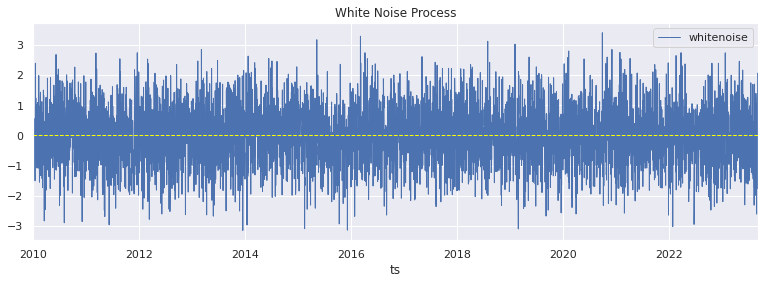

In [0]:
# Original Time Series
sns.set(rc={'figure.figsize':(13, 4), "lines.linewidth": 1.0})
series.plot(title='White Noise Process')
plt.axhline(y=0, color='yellow', linestyle='--', linewidth=1.0)

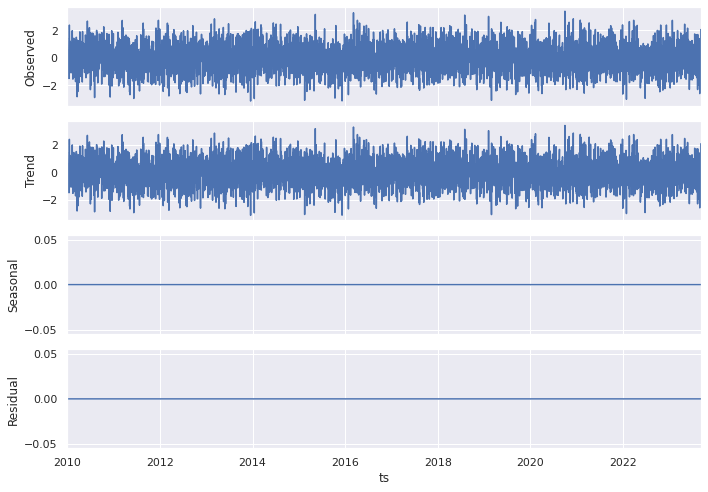

In [0]:
# Time Series Decomposition
sns.set(rc={'figure.figsize':(10, 7)})
decompose = series
result = seasonal_decompose(decompose, model='additive', freq=1) # or multiplicative
# print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)
result.plot()
pyplot.show()

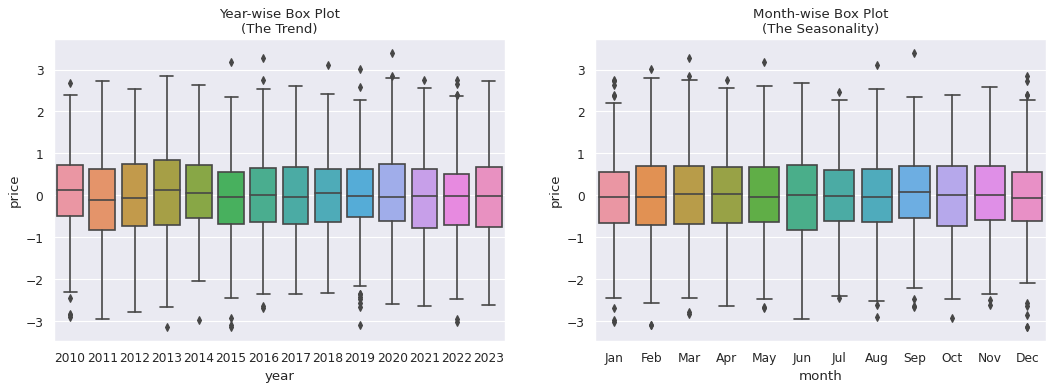

In [0]:
# Import Data
seasonal_plots = series.copy()

# Transform Series
seasonal_plots.reset_index(inplace=True)
seasonal_plots = seasonal_plots.rename(columns={"ts": "date", "whitenoise" : "price"})

# Prepare Data
seasonal_plots['year'] = [d.year for d in seasonal_plots.date]
seasonal_plots['month'] = [d.strftime('%b') for d in df.date]
years = seasonal_plots['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(16,5), dpi= 80)
sns.boxplot(x='year', y='price', data=seasonal_plots, ax=axes[0])
sns.boxplot(x='month', y='price', data=seasonal_plots.loc[~seasonal_plots.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=12); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=12)

plt.show()

As expected no trend or seasonality visible in both of plots.

## **Statistical Tests**

**Augmented Dickey Fuller**

* The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.
* H0: There is a unit root for the series (non stationary).

Choose regression {‘c’,’ct’,’ctt’,’nc’} - Constant and trend order to include in regression.
* ‘c’ : constant only (default).
* 'ct’ : constant and trend.
* ctt’ : constant, and linear and quadratic trend.
* 'nc’ : no constant, no trend.

In [0]:
# Augmented Dickey Fuller. H0: There is a unit root for the series (non stationary)
statsmodels.tsa.stattools.adfuller(series.whitenoise, maxlag=None, regression='ctt', autolag='AIC', store=False, regresults=False)

(-51.655529537354894,
 0.0,
 1,
 4998,
 {'1%': -4.373450004009452,
  '10%': -3.553992425283714,
  '5%': -3.8335721135923864},
 14024.439778510303)

P-value is zero. Reject H0. Series is stationary.

**KPSS Test**

* Kwiatkowski-Phillips-Schmidt-Shin to test if time series is stationarity. Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary. Stationarity Test: KPSS
* H0: Series has no unit root (is stationary or a deterministic trend). Ha: Series is not stationary
* Reject H0 if  p-value of less than 5% and test stats higher than provided critical values

**Cautions**

* A major disadvantage for the KPSS test is that it has a high rate of Type I errors (it tends to reject the null hypothesis too often). If attempts are made to control these errors (by having larger p-values), then that negatively impacts the test’s power.

* One way to deal with the potential for high Type I errors is to combine the KPSS with an ADF test. If the result from both tests suggests that the time series in stationary, then it probably is.

* https://www.statisticshowto.datasciencecentral.com/kpss-test/

**KPSS - Level Stationarity Test**

* ‘c’ : The data is stationary around a constant (default).
* H0 = Stationary (Stochastic Trend). H1 = Non-Stationary (Unit Root)
* Reject H0 if p-value of less than 5% and test stats higher than provided critical values

In [0]:
# KPSS - Level Stationarity Test. H0 = Stationary (Stochastic Trend). H1 = Non-Stationary (Unit Root)
statsmodels.tsa.stattools.kpss(series.whitenoise, regression='c', lags='auto', store=False)

Test statistics at 0.07 is not more extreme than the provided critical value of 0.46 for 5%. p-value is not below 0.05. Do not reject H0. Process is stationary around a constant.


**KPSS - Trend Stationary Test**

* ‘ct’ : The data is stationary around a trend.
* H0 = Deterministic Trend. H1 = Non-Stationary (Unit Root)
* Reject H0 if p-value of less than 5% and test stats higher than provided critical values

In [0]:
# KPSS - Trend Stationary Test. H0 = Deterministic Trend. H1 = Non-Stationary (Unit Root)
statsmodels.tsa.stattools.kpss(series.whitenoise, regression='ct', lags='auto', store=False)

Test statistics is smaller than provided critical value of 0.146. p-value is at 0.1 (“not significant”). Do not reject H0.

Summary: Both test show no unit root. Time series is either trend or level stationary.

**Zivot-Andrews Structural-break**

* Unit root tests can be wrong if a structural break occurred in timeseries. Zivot-Andrews test checks for structural Break Unit Root.
* H0 = unit root with a single structural break

In [0]:
# Determine number of lags required for Zivot-Andrews test
np.int_(12*(periods/100)**(1/4))

In [0]:
# Zivot-Andrews Structural-break Test
statsmodels.tsa.stattools.zivot_andrews(series.whitenoise, maxlag=(np.int_(12*(periods/100)**(1/4))), regression='ct', autolag='AIC')
# https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.zivot_andrews.html
# statsmodels.__version__

# **Time Series Transformations**

* Following transformations are possible to make a time series stationary
* Differencing is appied for stochastic / difference stationary processes
* Log, square root etc can be applied on deterministic trends
* After each transformation you can look at the distribution plot, QQ plot, autocorrelation plot and conduct normal distribution test, Augmented Dickey Fuller & KPSS test, to check if there is still a signal left.
* Of course a transformation of white noise processes will not change that there is no predictable pattern. This part is purely for completeness applicable at non-white noise processes.

**Difference**

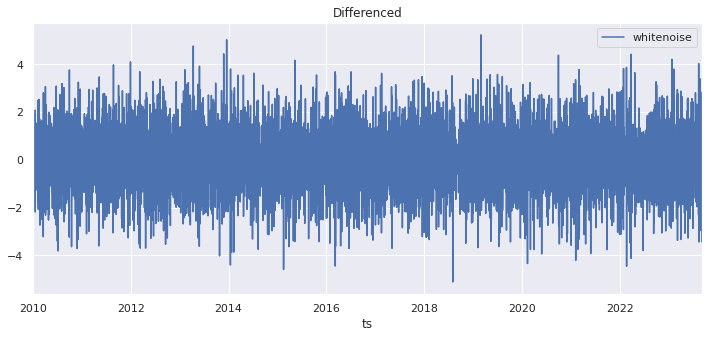

In [0]:
# Differenced
sns.set(rc={'figure.figsize':(12, 5)})
differenced = series - series.shift(1)
differenced.plot(title='Differenced')

**Percentage Difference**

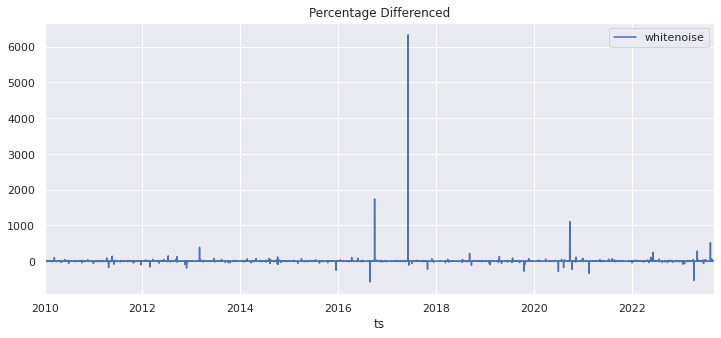

In [0]:
# Percentage Differenced
sns.set(rc={'figure.figsize':(12, 5)})
percentage = series / series.shift(1) -1
percentage.plot(title='Percentage Differenced')

**Log Return**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


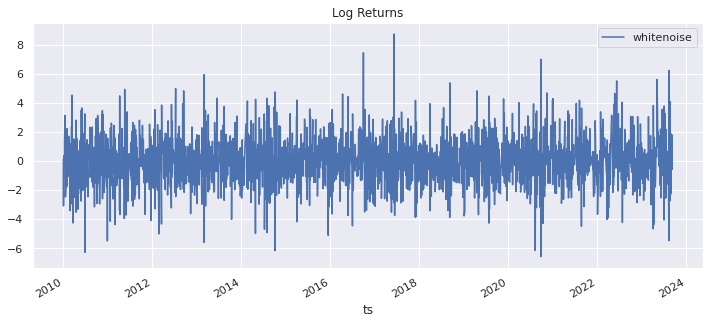

In [0]:
# Log Return
sns.set(rc={'figure.figsize':(12, 5)})
lr = np.log(series/series.shift(1)).dropna()
lr.plot(title='Log Returns')

**Square Root**

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


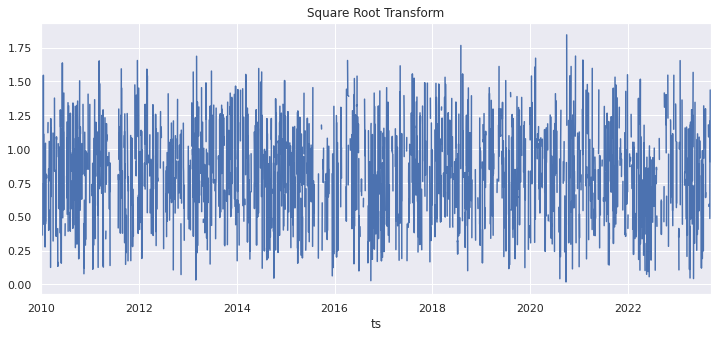

In [0]:
# Square Root Transform
sns.set(rc={'figure.figsize':(12, 5)})
sr = np.sqrt(series.whitenoise)
sr.plot(title='Square Root Transform')

**First Derivative**

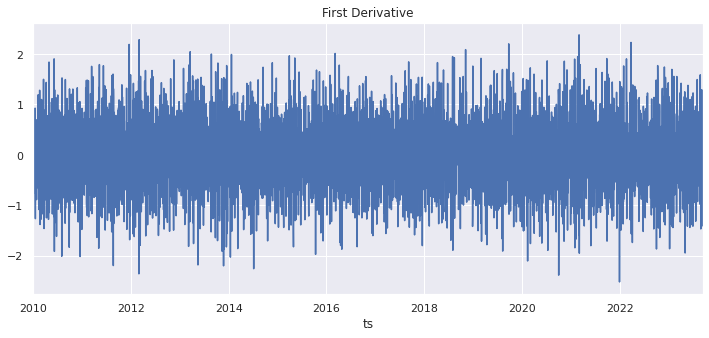

In [0]:
# First Derivative
sns.set(rc={'figure.figsize':(12, 5)})
fd = pd.Series(np.gradient(series.whitenoise), series.whitenoise.index, name='slope')
fd.plot(title='First Derivative')